# Sales Data Analysis of Chocolate Sales

## 1. Introduction

## 2. Data loading and first look

In [1]:
import kagglehub
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
path = kagglehub.dataset_download("atharvasoundankar/chocolate-sales")
csv_path = os.path.join(path, "Chocolate Sales.csv")

df = pd.read_csv(csv_path)
df.head()


,Sales Person,Country,Product,Date,Amount,Boxes Shipped
0,Jehu Rudeforth,UK,Mint Chip Choco,04-Jan-22,"$5,320",180
1,Van Tuxwell,India,85% Dark Bars,01-Aug-22,"$7,896",94
2,Gigi Bohling,India,Peanut Butter Cubes,07-Jul-22,"$4,501",91
3,Jan Morforth,Australia,Peanut Butter Cubes,27-Apr-22,"$12,726",342
4,Jehu Rudeforth,UK,Peanut Butter Cubes,24-Feb-22,"$13,685",184


We will see a basic information about the dataset, to look for any anomalies or missing values.

In [3]:
print(f"rows: {df.shape[0]}, columns: {df.shape[1]}")
df.info()

rows: 1094, columns: 6
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094 entries, 0 to 1093
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Sales Person   1094 non-null   object
 1   Country        1094 non-null   object
 2   Product        1094 non-null   object
 3   Date           1094 non-null   object
 4   Amount         1094 non-null   object
 5   Boxes Shipped  1094 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 51.4+ KB


Check possible NaNs

In [4]:
df.isnull().sum()

Sales Person     0
Country          0
Product          0
Date             0
Amount           0
Boxes Shipped    0
dtype: int64

In [5]:
df["Date"] = pd.to_datetime(df["Date"])

print("Date range:", df["Date"].min(), "->", df["Date"].max())

Date range: 2022-01-03 00:00:00 -> 2022-08-31 00:00:00


/var/folders/6h/f4b9pqr55319d7smk2pl0wdw0000gn/T/ipykernel_23758/4151490514.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"])


In [6]:
duplicates = df.duplicated()
print(f"duplicated rows: {duplicates.sum()}")

duplicated rows: 0


We can see that this dataset is so clean, that will make our life easier.

## 3. Cleaning the data

In [7]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
df.head()

,sales_person,country,product,date,amount,boxes_shipped
0,Jehu Rudeforth,UK,Mint Chip Choco,2022-01-04,"$5,320",180
1,Van Tuxwell,India,85% Dark Bars,2022-08-01,"$7,896",94
2,Gigi Bohling,India,Peanut Butter Cubes,2022-07-07,"$4,501",91
3,Jan Morforth,Australia,Peanut Butter Cubes,2022-04-27,"$12,726",342
4,Jehu Rudeforth,UK,Peanut Butter Cubes,2022-02-24,"$13,685",184


In [8]:
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["amount"] = df["amount"].replace(r"[\$,]", "", regex=True).astype(float)

df.head()

,sales_person,country,product,date,amount,boxes_shipped
0,Jehu Rudeforth,UK,Mint Chip Choco,2022-01-04,5320.0,180
1,Van Tuxwell,India,85% Dark Bars,2022-08-01,7896.0,94
2,Gigi Bohling,India,Peanut Butter Cubes,2022-07-07,4501.0,91
3,Jan Morforth,Australia,Peanut Butter Cubes,2022-04-27,12726.0,342
4,Jehu Rudeforth,UK,Peanut Butter Cubes,2022-02-24,13685.0,184


## 4. Exploratory data analysis (EDA)

I think that in business intelligence, the most important thing is to understand the data and the business. So, I will try to make some analysis that can be useful for a business.

I will explain the analysis answering four basic questions:
1. Which are the most sold chocolates?
2. Where are the most sold chocolates?
3. When are the most sold chocolates?
4. How are the most sold chocolates?

It is a subjective decission, but for a first analysis I think that will be far enough to understand the data and the business.

### 4.1. WHICH is the best-selling chocolate?

/var/folders/6h/f4b9pqr55319d7smk2pl0wdw0000gn/T/ipykernel_23758/2345271493.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=product_revenue.values, y=product_revenue.index, palette="viridis")


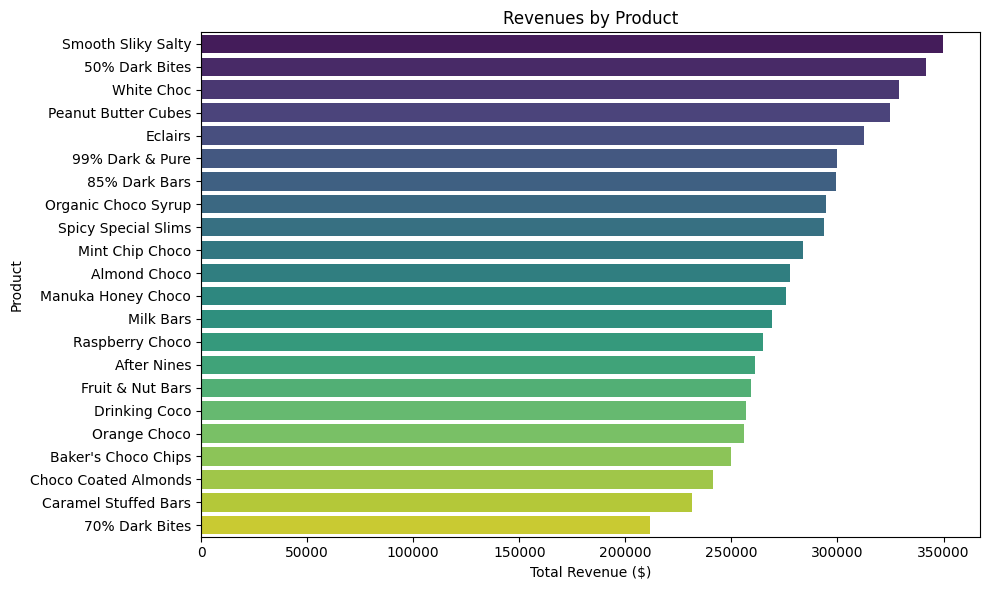

In [9]:
product_revenue = df.groupby('product')['amount'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=product_revenue.values, y=product_revenue.index, palette="viridis")
plt.title("Revenues by Product")
plt.xlabel("Total Revenue ($)")
plt.ylabel("Product")
plt.tight_layout()
plt.show()

### 4.2. WHERE is selling the most chocolate?

/var/folders/6h/f4b9pqr55319d7smk2pl0wdw0000gn/T/ipykernel_23758/248236132.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_revenue.values, y=country_revenue.index, palette="magma")


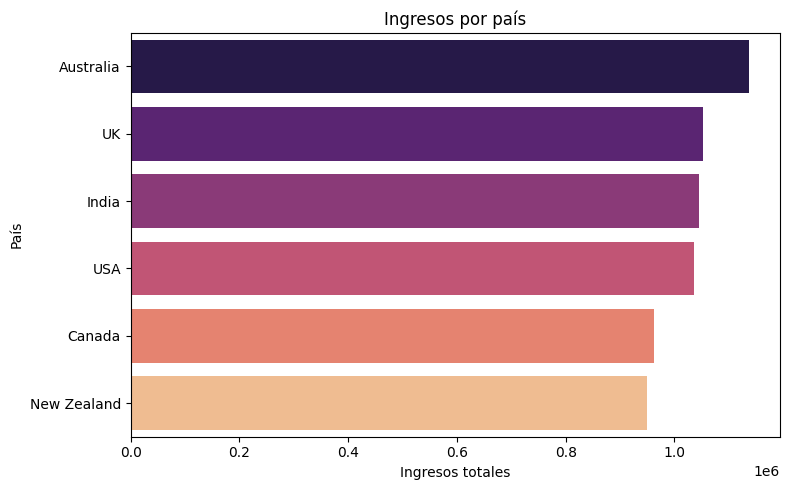

In [10]:
country_revenue = df.groupby('country')['amount'].sum().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=country_revenue.values, y=country_revenue.index, palette="magma")
plt.title("Ingresos por país")
plt.xlabel("Ingresos totales")
plt.ylabel("País")
plt.tight_layout()
plt.show()

In [11]:
# Convert country_revenue to a DataFrame
country_revenue_df = country_revenue.reset_index()
country_revenue_df.columns = ['country', 'total_revenue']

# Create a map
fig = px.choropleth(
    country_revenue_df,
    locations="country",
    locationmode="country names",
    color="total_revenue",
    color_continuous_scale=px.colors.sequential.Viridis[::-1],
    title="Revenues by Country",
    labels={"total_revenue": "Total Revenue ($)"},
)

fig.update_layout(geo=dict(showframe=False, projection_type="natural earth"))
fig.show()

### 4.3. WHEN is selling the most chocolate?

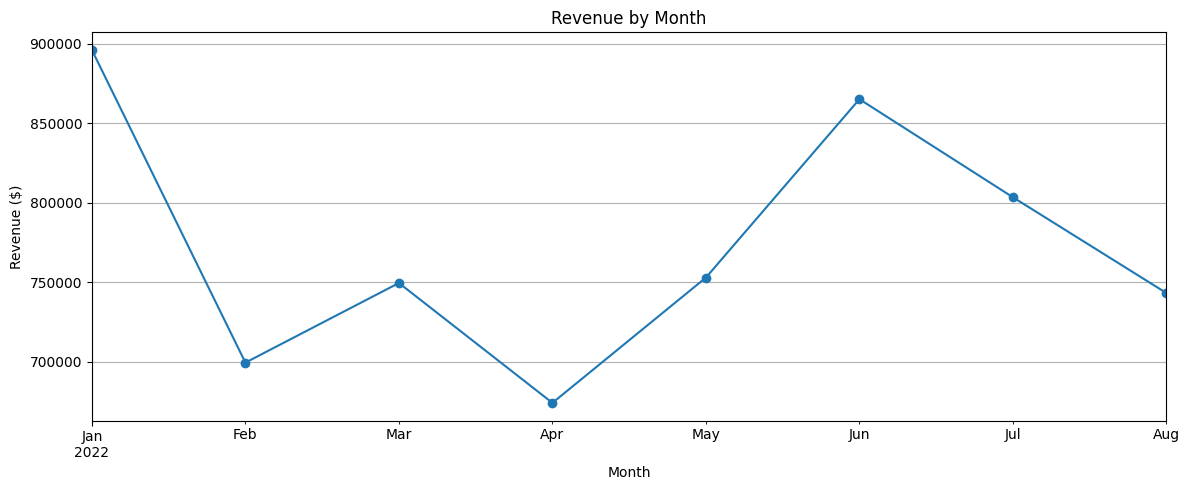

In [12]:
df['month'] = df['date'].dt.to_period('M')
monthly_revenue = df.groupby('month')['amount'].sum()

plt.figure(figsize=(12, 5))
monthly_revenue.plot(marker='o')
plt.title("Revenue by Month")
plt.xlabel("Month")
plt.ylabel("Revenue ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

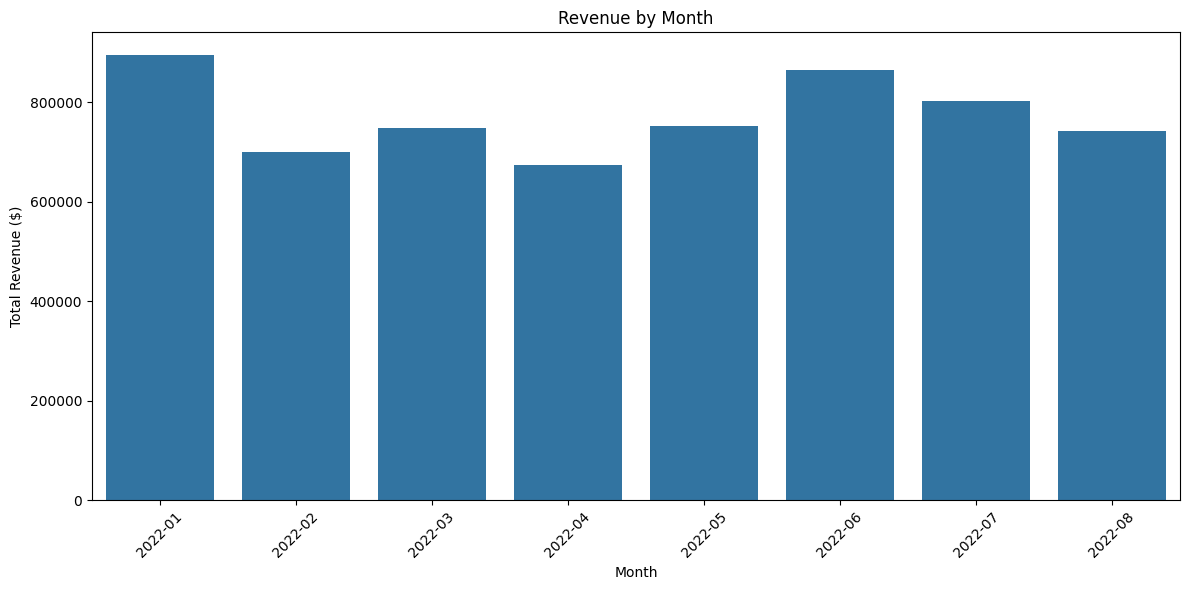

In [13]:
df['month'] = df['date'].dt.to_period('M').astype(str)

monthly_revenue = df.groupby('month')['amount'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='month', y='amount', data=monthly_revenue)
plt.xticks(rotation=45)
plt.title("Revenue by Month")
plt.xlabel("Month")
plt.ylabel("Total Revenue ($)")
plt.tight_layout()
plt.show()

### 4.4. HOW is selling the most chocolate?

As we could see, our dataset hasn't lot of columns, so is complicated to extract rigorous conclusions. But I conclude that it's possible to know the behavior of th sales with a perspective of volume and segmentation.

In [14]:
df['price_per_box'] = df['amount'] / df['boxes_shipped']
df.head()

,sales_person,country,product,date,amount,boxes_shipped,month,price_per_box
0,Jehu Rudeforth,UK,Mint Chip Choco,2022-01-04,5320.0,180,2022-01,29.555556
1,Van Tuxwell,India,85% Dark Bars,2022-08-01,7896.0,94,2022-08,84.000000
2,Gigi Bohling,India,Peanut Butter Cubes,2022-07-07,4501.0,91,2022-07,49.461538
3,Jan Morforth,Australia,Peanut Butter Cubes,2022-04-27,12726.0,342,2022-04,37.210526
4,Jehu Rudeforth,UK,Peanut Butter Cubes,2022-02-24,13685.0,184,2022-02,74.375000


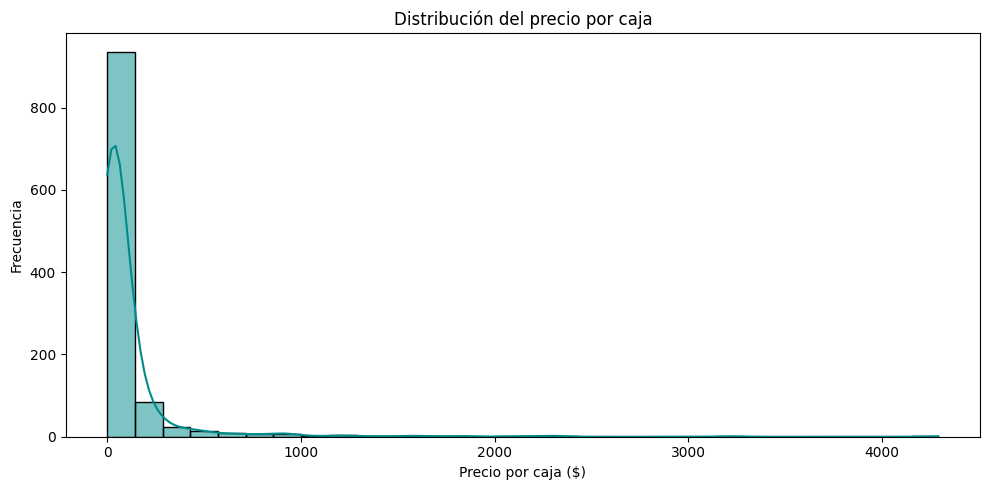

In [15]:
plt.figure(figsize=(10, 5))
sns.histplot(df['price_per_box'], bins=30, kde=True, color='darkcyan')
plt.title("Distribución del precio por caja")
plt.xlabel("Precio por caja ($)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

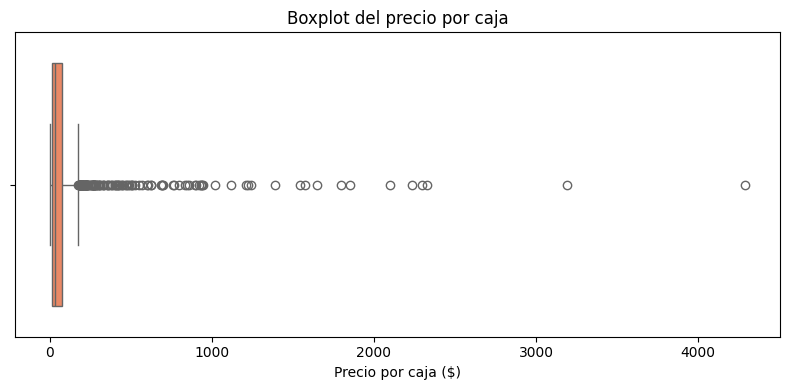

In [16]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['price_per_box'], color='coral')
plt.title("Boxplot del precio por caja")
plt.xlabel("Precio por caja ($)")
plt.tight_layout()
plt.show()

segmentation

In [17]:
df['order_size'] = pd.cut(
    df['boxes_shipped'],
    bins=[0, 10, 50, df['boxes_shipped'].max()],
    labels=['small', 'medium', 'large']
)
df.head()

,sales_person,country,product,date,amount,boxes_shipped,month,price_per_box,order_size
0,Jehu Rudeforth,UK,Mint Chip Choco,2022-01-04,5320.0,180,2022-01,29.555556,large
1,Van Tuxwell,India,85% Dark Bars,2022-08-01,7896.0,94,2022-08,84.000000,large
2,Gigi Bohling,India,Peanut Butter Cubes,2022-07-07,4501.0,91,2022-07,49.461538,large
3,Jan Morforth,Australia,Peanut Butter Cubes,2022-04-27,12726.0,342,2022-04,37.210526,large
4,Jehu Rudeforth,UK,Peanut Butter Cubes,2022-02-24,13685.0,184,2022-02,74.375000,large


In [18]:
segment_stats = df.groupby('order_size').agg({
    'amount': ['sum', 'mean'],
    'price_per_box': 'mean',
    'boxes_shipped': 'mean'
}).round(2)

segment_stats

/var/folders/6h/f4b9pqr55319d7smk2pl0wdw0000gn/T/ipykernel_23758/1130469969.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



amount          price_per_box boxes_shipped
                  sum     mean          mean          mean
order_size                                                
small        182385.0  5526.82        1186.4          5.91
medium       950873.0  6056.52         250.1         30.34
large       5050367.0  5586.69          41.2        190.32

In [19]:
segment_stats.columns = ['total_revenue', 'avg_revenue', 'avg_price_per_box', 'avg_boxes']
segment_stats.reset_index(inplace=True)
segment_stats

,order_size,total_revenue,avg_revenue,avg_price_per_box,avg_boxes
0,small,182385.0,5526.82,1186.4,5.91
1,medium,950873.0,6056.52,250.1,30.34
2,large,5050367.0,5586.69,41.2,190.32


/var/folders/6h/f4b9pqr55319d7smk2pl0wdw0000gn/T/ipykernel_23758/2997182493.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/6h/f4b9pqr55319d7smk2pl0wdw0000gn/T/ipykernel_23758/2997182493.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




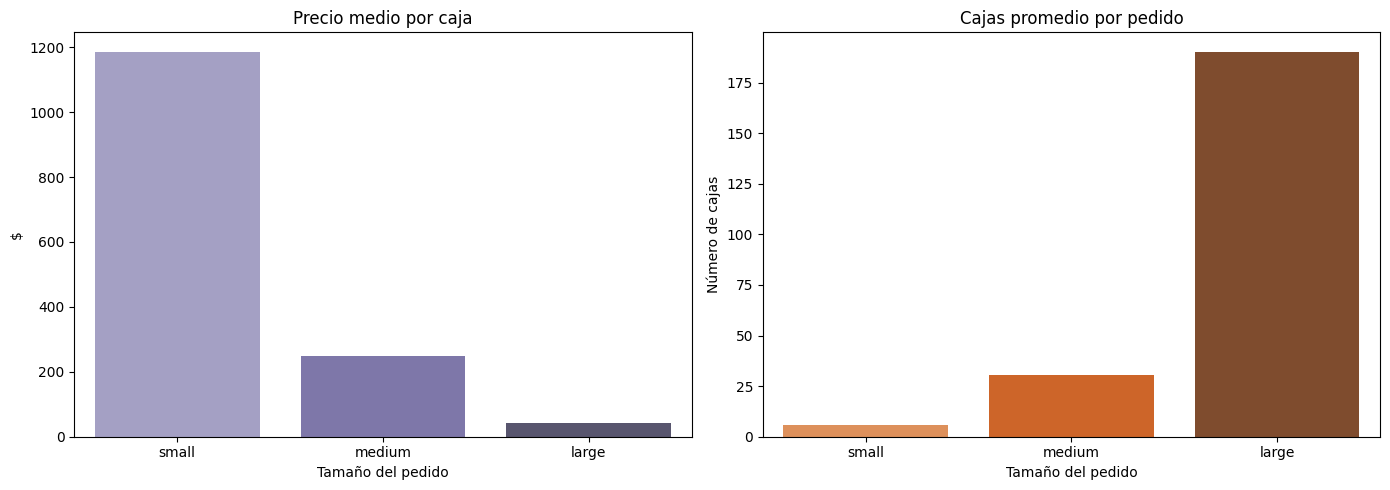

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(data=segment_stats, x='order_size', y='avg_price_per_box', ax=ax[0], palette='Purples_d')
ax[0].set_title("Precio medio por caja")
ax[0].set_xlabel("Tamaño del pedido")
ax[0].set_ylabel("$")

sns.barplot(data=segment_stats, x='order_size', y='avg_boxes', ax=ax[1], palette='Oranges_d')
ax[1].set_title("Cajas promedio por pedido")
ax[1].set_xlabel("Tamaño del pedido")
ax[1].set_ylabel("Número de cajas")

plt.tight_layout()
plt.show()

## 5. Conclusion

In [21]:
segment_stats['revenue_per_box'] = segment_stats['avg_revenue'] / segment_stats['avg_boxes']

/var/folders/6h/f4b9pqr55319d7smk2pl0wdw0000gn/T/ipykernel_23758/1034175354.py:1: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




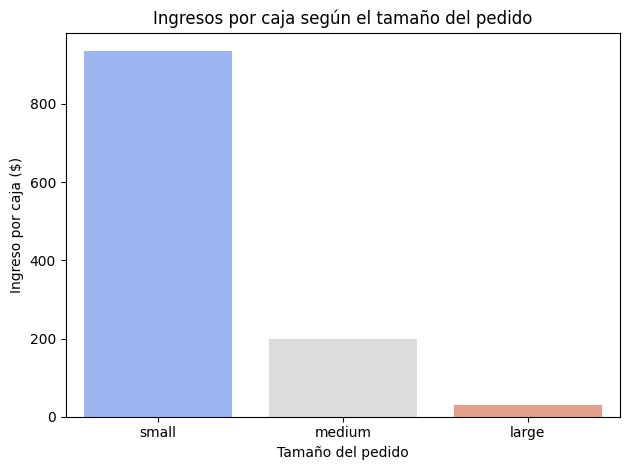

In [22]:
sns.barplot(data=segment_stats, x='order_size', y='revenue_per_box', palette='coolwarm')
plt.title("Ingresos por caja según el tamaño del pedido")
plt.ylabel("Ingreso por caja ($)")
plt.xlabel("Tamaño del pedido")
plt.tight_layout()
plt.show()

with simulated costs

In [23]:
unit_box_cost = 12
df["cost"] = df["boxes_shipped"] * unit_box_cost
df["cost"]


0       2160
1       1128
2       1092
3       4104
4       2208
        ... 
1089    3876
1090    1428
1091    2604
1092    4608
1093    4128
Name: cost, Length: 1094, dtype: int64

But this calculus of costs is so basic. Moreover is a simulation, we can do it better including the costs of the chocolate, the taxes and the logistics. Is not 100% accurate, but is a good approximation to understand the behavior of the sales.

In [24]:
def calculate_cost_row(row):
    # Static costs
    chocolate_cost = 7 * row["boxes_shipped"]
    tax_cost = 0.10 * row["amount"]

    # Variable costs
    if row["boxes_shipped"] <= 10:
        logistic_cost_box = 5
    elif row["boxes_shipped"] <= 50:
        logistic_cost_box = 3
    else:
        logistic_cost_box = 1.5

    logistic_cost = logistic_cost_box * row["boxes_shipped"]

    # Total cost
    total_cost = chocolate_cost + tax_cost + logistic_cost
    return chocolate_cost, tax_cost, logistic_cost, total_cost

In [25]:
df[['chocolate_cost', 'tax_cost', 'logistic_cost', 'cost']] = df.apply(calculate_cost_row, axis=1, result_type='expand')
df["profit"] = df["amount"] - df["cost"]
df["profit_margin"] = (df["profit"] / df["amount"]) * 100

df.head()

,sales_person,country,product,date,amount,boxes_shipped,month,price_per_box,order_size,cost,chocolate_cost,tax_cost,logistic_cost,profit,profit_margin
0,Jehu Rudeforth,UK,Mint Chip Choco,2022-01-04,5320.0,180,2022-01,29.555556,large,2062.0,1260.0,532.0,270.0,3258.0,61.240602
1,Van Tuxwell,India,85% Dark Bars,2022-08-01,7896.0,94,2022-08,84.000000,large,1588.6,658.0,789.6,141.0,6307.4,79.880952
2,Gigi Bohling,India,Peanut Butter Cubes,2022-07-07,4501.0,91,2022-07,49.461538,large,1223.6,637.0,450.1,136.5,3277.4,72.814930
3,Jan Morforth,Australia,Peanut Butter Cubes,2022-04-27,12726.0,342,2022-04,37.210526,large,4179.6,2394.0,1272.6,513.0,8546.4,67.157001
4,Jehu Rudeforth,UK,Peanut Butter Cubes,2022-02-24,13685.0,184,2022-02,74.375000,large,2932.5,1288.0,1368.5,276.0,10752.5,78.571429


/var/folders/6h/f4b9pqr55319d7smk2pl0wdw0000gn/T/ipykernel_23758/3694335548.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



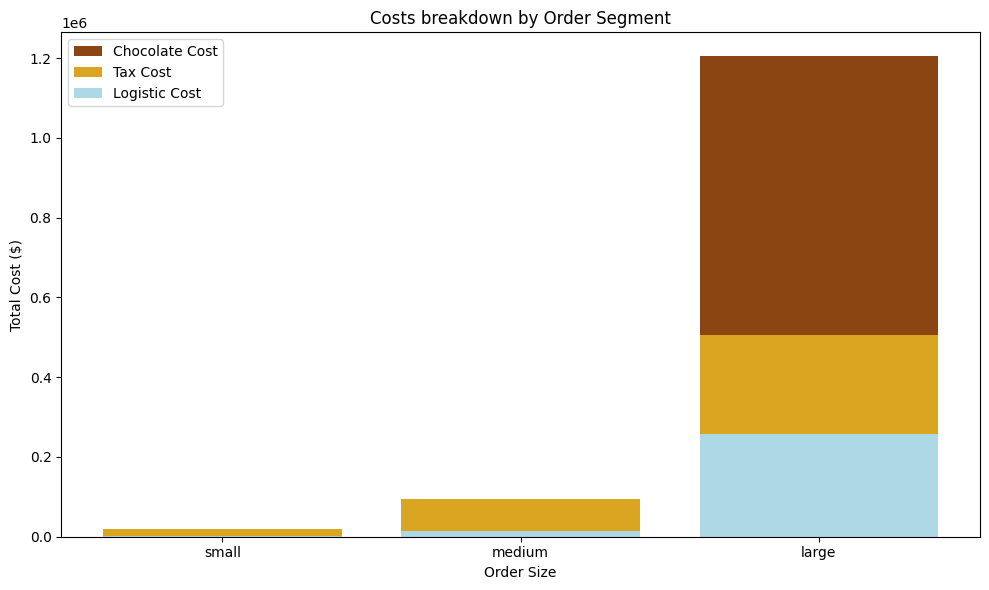

In [27]:
segmented_costs = df.groupby("order_size")[["chocolate_cost", "tax_cost", "logistic_cost", "cost"]].sum().reset_index()

labels = segmented_costs["order_size"]
chocolate = segmented_costs["chocolate_cost"]
tax = segmented_costs["tax_cost"]
logistic = segmented_costs["logistic_cost"]

plt.figure(figsize=(10, 6))
plt.bar(labels, chocolate, label="Chocolate Cost", color="saddlebrown")
plt.bar(labels, tax, label="Tax Cost", color="goldenrod")
plt.bar(labels, logistic, label="Logistic Cost", color="lightblue")

plt.title("Costs breakdown by Order Segment")
plt.xlabel("Order Size")
plt.ylabel("Total Cost ($)")
plt.legend()
plt.tight_layout()
plt.show()

benefits

In [28]:
benefits = df.groupby("order_size").agg({"amount": "sum", "cost": "sum", "profit": "sum"}).round(2)

benefits["profit_margin"] = (benefits["profit"] / benefits["amount"]) * 100
benefits = benefits.round(2)
benefits

/var/folders/6h/f4b9pqr55319d7smk2pl0wdw0000gn/T/ipykernel_23758/378580783.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,amount,cost,profit,profit_margin
order_size,,,,
small,182385.0,20578.5,161806.5,88.72
medium,950873.0,142727.3,808145.7,84.99
large,5050367.0,1967444.7,3082922.3,61.04


/var/folders/6h/f4b9pqr55319d7smk2pl0wdw0000gn/T/ipykernel_23758/1242547411.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




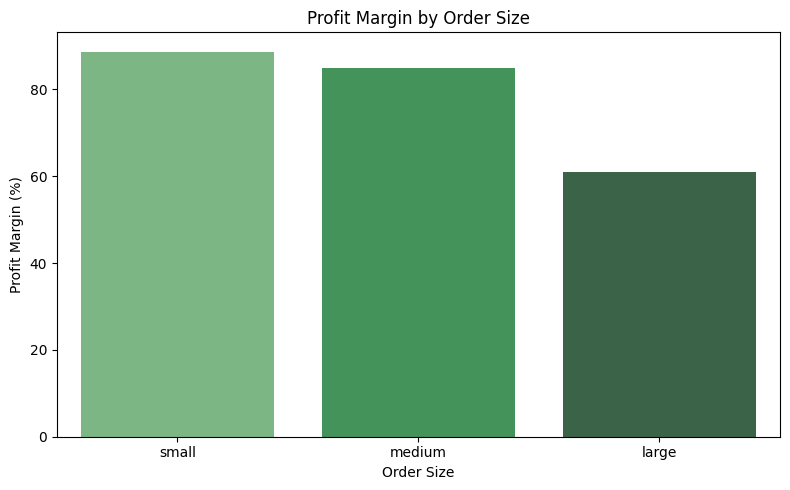

In [29]:
plt.figure(figsize=(8, 5))
sns.barplot(x=benefits.index, y=benefits["profit_margin"], palette="Greens_d")
plt.title("Profit Margin by Order Size")
plt.xlabel("Order Size")
plt.ylabel("Profit Margin (%)")
plt.tight_layout()
plt.show()